In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8ABemAQBDrfwJr6Wtbt9")
project = rf.workspace("augmentation-test").project("accident-finder")
version = project.version(3)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to accident-finder-3 in yolov8:: 100%|██████████| 16827/16827 [00:06<00:00, 2517.08it/s]


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
current_train_images_dir = 'accident-finder-3/train/images'
current_train_labels_dir = 'accident-finder-3/train/labels'
current_valid_images_dir = 'accident-finder-3/valid/images'
current_valid_labels_dir = 'accident-finder-3/valid/labels'

new_base_dir = 'New Dataset'
new_train_dir = os.path.join(new_base_dir, 'train')
new_valid_dir = os.path.join(new_base_dir, 'valid')
new_test_dir = os.path.join(new_base_dir, 'test')

# Create the new directories
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_valid_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

# Get all image and label files
train_images = [os.path.join(current_train_images_dir, f) for f in os.listdir(current_train_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
train_labels = [os.path.join(current_train_labels_dir, f) for f in os.listdir(current_train_labels_dir) if f.endswith('.txt')]

valid_images = [os.path.join(current_valid_images_dir, f) for f in os.listdir(current_valid_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
valid_labels = [os.path.join(current_valid_labels_dir, f) for f in os.listdir(current_valid_labels_dir) if f.endswith('.txt')]

# Combine train and valid images and labels
all_images = train_images + valid_images
all_labels = train_labels + valid_labels

# Ensure there are corresponding labels for each image
all_images, all_labels = zip(*[(img, lbl) for img, lbl in zip(all_images, all_labels) if os.path.exists(lbl)])

# Split dataset 80-10-10
train_imgs, temp_imgs, train_lbls, temp_lbls = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
valid_imgs, test_imgs, valid_lbls, test_lbls = train_test_split(temp_imgs, temp_lbls, test_size=0.5, random_state=42)

# Function to move files
def move_files(images, labels, dest_dir):
    img_dest_dir = os.path.join(dest_dir, 'images')
    lbl_dest_dir = os.path.join(dest_dir, 'labels')
    
    os.makedirs(img_dest_dir, exist_ok=True)
    os.makedirs(lbl_dest_dir, exist_ok=True)

    for img, lbl in zip(images, labels):
        shutil.copy(img, img_dest_dir)
        shutil.copy(lbl, lbl_dest_dir)

# Move the files to respective folders
move_files(train_imgs, train_lbls, new_train_dir)
move_files(valid_imgs, valid_lbls, new_valid_dir)
move_files(test_imgs, test_lbls, new_test_dir)

print("Dataset split and moved successfully!")


Dataset split and moved successfully!


In [2]:
!pip install tqdm ipywidgets


   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.3 MB ? eta -:--:--
   ---------------------- ----------------- 1.3/2.3 MB 3.5 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.3 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 3.7 MB/s eta 0:00:00


In [3]:
from tqdm.notebook import tqdm

# Enable the widget-based tqdm progress bars in Jupyter
tqdm.pandas()


In [ ]:
!yolo train data=Dataset/data.yaml model=yolov8n.pt epochs=100 imgsz=640 amp=false

In [1]:
import cv2
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO('runs/detect/train2/weights/best.pt')  # Replace with your model path

# Open the video file or capture from a webcam
video_path = 'Demo/test3-1.mp4'  # Replace with your video path
cap = cv2.VideoCapture(video_path)

# Define the class index for "accident" (assuming 0 is for accident and 1 is for no-accident)
accident_class_index = 0  # Update this based on your class index for accident

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Perform inference
    results = model(frame)

    # Process results
    for result in results:
        boxes = result.boxes  # Get the boxes from the result
        for box in boxes:
            cls = int(box.cls[0])  # Class ID
            
            # Only draw bounding boxes for the "accident" class
            if cls == accident_class_index:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get box coordinates
                conf = box.conf[0]  # Confidence score
                if(conf>0.9):
                # Draw bounding box and label on the frame
                  label = f'Accident: {conf:.2f}'
                  cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)  # Draw box
                  cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show the processed frame
    cv2.imshow('YOLOv8 Detection', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


c:\Program Files\Python310\lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # 


0: 384x640 1 accident, 1 non-accident, 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


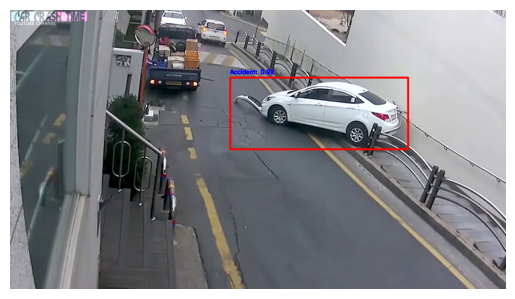

In [12]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the trained YOLO model
model = YOLO('runs/detect/train2/weights/best.pt')  # Replace with your model path

# Specify the path to the image you want to test
image_path = 'Demo/test10_38.jpg'  # Replace with your image path

# Read the image
frame = cv2.imread(image_path)

# Perform inference
results = model(frame)

# Process results
for result in results:
    boxes = result.boxes  # Get the boxes from the result
    for box in boxes:
        cls = int(box.cls[0])  # Class ID
        
        # Only draw bounding boxes for the "accident" class (assumed to be class 0)
        if cls == 0:  # Change this if necessary
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get box coordinates
            conf = box.conf[0]  # Confidence score
            
            # Draw bounding box and label on the frame
            label = f'Accident: {conf:.2f}'
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)  # Draw box
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Convert the image from BGR to RGB format
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Show the processed image using matplotlib
plt.imshow(frame_rgb)
plt.axis('off')  # Hide axes
plt.show()  # Display the image
